In [1]:
import sys
if not '../' in sys.path:
    sys.path.append('../')

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Activation, Layer
 
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
import pandas as pd
from sklearn import preprocessing
import numpy as np
import io
import os
import random
from datetime import datetime

from envs.stocks_env import Stocks_env
from datasets import nyse
from models.lstm_selfattention import ActorCritic

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use GPU</h2>

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
print(tf.config.experimental.list_logical_devices('GPU'))
tf.test.is_gpu_available()

# set up policy used in mixed precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)

1 Physical GPUs, 1 Logical GPUs
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

<h2>Create Environments</h2>

In [4]:
data = nyse.load_data('../../data/')

<h2>Neural Network</h2>

<h2>GAE and PPO</h2>

In [5]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

In [6]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = tf.shape(states)[0]
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states.numpy()[rand_ids, :], actions.numpy()[rand_ids, :], log_probs.numpy()[rand_ids, :], returns.numpy()[rand_ids, :], advantage.numpy()[rand_ids, :]

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            with tf.GradientTape() as tape:
                # value, dist = model(state, np.reshape(state[:,-1,:],(batch_size, 1, num_inputs[1])))
                value, dist = model(state)
                        
                entropy = tf.math.reduce_mean(dist.entropy())
                new_log_probs = dist.log_prob(action)

                ratio = tf.math.exp(new_log_probs - old_log_probs)
                surr1 = ratio * advantage
                surr2 = tf.clip_by_value(ratio, clip_value_min=1.0 - clip_param, 
                                         clip_value_max=1.0 + clip_param) * advantage

                actor_loss  = - tf.math.reduce_mean(tf.math.minimum(surr1, surr2))
                critic_loss = tf.math.reduce_mean(tf.math.pow(return_ - value, 2))

                loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy
                
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

<h2>Train</h2>

In [7]:
batch_size = 3
window_size = 32
run_lenght = 32

# Hyper params:
lr               = 3e-4
run_lenght       = 32
batch_size       = 128
window_size      = 32
ppo_epochs       = 4
num_epochs       = 3000
test_iterations  = 1
threshold_reward = 400
happiness_alpha  = 0.9
happiness_beta   = 0.03
hidden_dim       = 1024
num_filters      = 64
lstm_units       = 1024
num_blocks       = 1

# log
log_freq = 1
models_directory = 'results/models/'
save_directory = 'results/saved-timesteps/'
date = datetime.now().strftime("%Y_%m_%d-%H:%M:%S")
identifier = "stonks-" + date
test_summary_writer = tf.summary.create_file_writer('results/summaries/test/' + identifier)
mean_reward = tf.keras.metrics.Mean(name='mean_reward')

# initialize env
env = Stocks_env(data, batch_size, window_size, run_lenght)
test_batch_size  = len(env.get_test_symbols())
num_inputs  = env.get_observation_space()
num_policies = env.get_action_space()

# initialize the model
model = ActorCritic(num_policies = num_policies, hidden_dim=hidden_dim, num_filters=num_filters, lstm_units=lstm_units)
optimizer = tf.keras.optimizers.Adam(lr)

In [8]:
# state = env.reset(trader_happiness=0)
# model(state, np.reshape(state[:,-1,:],(batch_size, 1, num_inputs[1])))
# model.load_weights('results/models/best-stonks-2020_09_20-08:08:45.h5')

In [9]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    plt.show()
    return image


def test_env(record_days=False):
    state = env.reset(trader_happiness=0, training=False, batch_size=test_batch_size)
    done = False
    total_reward = 0
    operation_array = []
    days_array = []
    while not done:
        # _, dist = model(state, np.reshape(state[:,-1,:],(test_batch_size, 1, num_inputs[1])))
        _, dist = model(state)
        next_state, reward, done, operations, day = env.step(dist.sample())
        state = next_state
        if record_days:
            operation_array.append(operations)
            days_array.append(day)
        total_reward += reward
    mean_reward(total_reward)
    return operation_array, days_array, total_reward

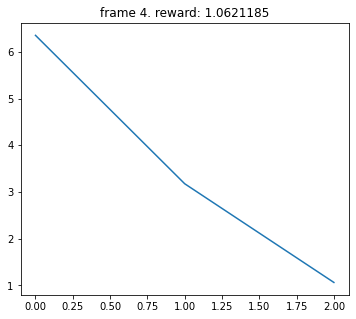

KeyboardInterrupt: 

In [10]:
early_stop = False
max_reward = 0
test_rewards = []
epoch  = 0

while epoch < num_epochs and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []

    state = env.reset(trader_happiness=(happiness_alpha**epoch)*happiness_beta, training=True,
                      batch_size=batch_size)

    for _ in range(run_lenght):
        # value, dist = model(state, np.reshape(state[:,-1,:],(batch_size, 1, num_inputs[1])))
        value, dist = model(state)

        action = dist.sample()
        next_state, reward, done, _, _ = env.step(action)

        log_prob = dist.log_prob(action)

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(tf.expand_dims((reward,), axis=1))
        masks.append(tf.expand_dims((float(1 - done),), axis=1))

        states.append(state)
        actions.append(action)

        state = next_state

    # next_value, _ = model(next_state, np.reshape(next_state[:,-1,:],(batch_size, 1, num_inputs[1])))
    next_value, _ = model(next_state)
    returns = compute_gae(next_value, rewards, masks, values)

    returns_save = returns
    
    returns   = tf.reshape(tf.concat(returns, axis=1),(run_lenght*batch_size,1))
    log_probs = tf.concat(log_probs, axis=0)
    values    = tf.concat(values, axis=0)
    states    = tf.concat(states, axis=0)
    actions   = tf.concat(actions, axis=0)

    advantage = returns - values
    advantage = tf.reshape(advantage,(run_lenght*batch_size,1))

    ppo_update(ppo_epochs, batch_size, states, actions, log_probs, returns, advantage)

    if epoch % 2 == 0:
        for i in range(test_iterations):
            operation_array, days_array, total_reward = test_env(record_days=(i==test_iterations-1))
        test_rewards.append(mean_reward.result().numpy())
        with test_summary_writer.as_default():
            tf.summary.scalar('mean_test_reward', mean_reward.result(), step=epoch)
            tf.summary.scalar('last_test_reward', total_reward[0], step=epoch)
            tf.summary.image('Plot', plot(epoch, test_rewards), step=epoch)
        if (mean_reward.result() > max_reward):
            # serialize weights to HDF5
            if not os.path.exists(save_directory):
                os.makedirs(save_directory)
            pd.DataFrame(operation_array).to_csv(save_directory+"{}-operation-epoch{}.csv".format(identifier, epoch), 
                                                 header=env.get_current_symbols(), index=None)
            pd.DataFrame(days_array).to_csv(save_directory+"{}-endingday-epoch{}.csv".format(identifier, epoch), 
                                                 header=env.get_current_symbols(), index=None)
            if not os.path.exists(models_directory):
                os.makedirs(models_directory)
            model.save_weights(models_directory + "best-{}.h5".format(identifier))
            max_reward = mean_reward.result()
        if (mean_reward.result() > threshold_reward): early_stop = True
        mean_reward.reset_states()

    epoch += 1